In [1]:
import sys
sys.path.extend(["../", "../src"])

In [2]:
from timeit import timeit

from tqdm import tqdm
import numpy as np
from scipy.stats import poisson

import matplotlib
import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from src.loss import phase_insensitive_loss_cvx
from src.gd_opt import learn_phase_insensitive_povm
from src.quantum import pnr_povm, diag_povm_fidelity, diag_mse_norm
from src.utils import check_diag_povm, find_lambda_max
from src.custom_types import Hyperparameters

matplotlib.rcParams.update({"font.size": 16})
plt.rcParams["figure.dpi"] = 125 #200  # set fig resolution
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

seed = 42  # for reproducibility
th.manual_seed(seed);

### Time complexity

In [3]:
Ms = range(100, 375, 25)
device = 'cpu'
N = 25
D = 2000
eta = 1.
lam_smoothing = 0e-5
number = 5
time_gd = []
time_mosek = []
iters_mosek = []
avg_fids_cco = []
avg_mses_cco = []
hyperparams = Hyperparameters(lr=0.01, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=100, batch_size=25)

In [ ]:
for M in tqdm(Ms, desc="Performing time experiments"):
    # PNR detector POVM
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_max(M, eps=1e-5)  # get max avg photon number for probes
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ]), dtype=th.float32) 

    targets = probes @ true_povm  

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False)

    Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
    
    if check_diag_povm(Pi.T, tol=1e-5) is not True:
        print(f"WARNING: Gradient descent got invalid solution POVM for M={M}")

    Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]

    Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")
    Pi = th.tensor(Pi)
    
    Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    avg_fids_cco.append(sum(Fs)/len(Fs))

    frobs = [ diag_mse_norm(Pi[:, i].to('cpu'), true_povm[:, i].to('cpu')) for i in range(true_povm.shape[1]) ]
    avg_mses_cco.append(sum(frobs)/len(frobs))

    if check_diag_povm(Pi.T, tol=1e-5) is not True:
        print(f"WARNING: CVXPY got invalid solution POVM for M={M}")

    iters_mosek.append(iters)

    # compute times
    t = timeit(lambda: learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False), number=number)
    time_gd.append(t / number) 

    t = timeit(lambda: phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK"), number=number) 
    time_mosek.append(t / number)

Performing time experiments:   0%|          | 0/11 [00:00<?, ?it/s]

Performing time experiments: 100%|██████████| 11/11 [43:59<00:00, 239.91s/it]


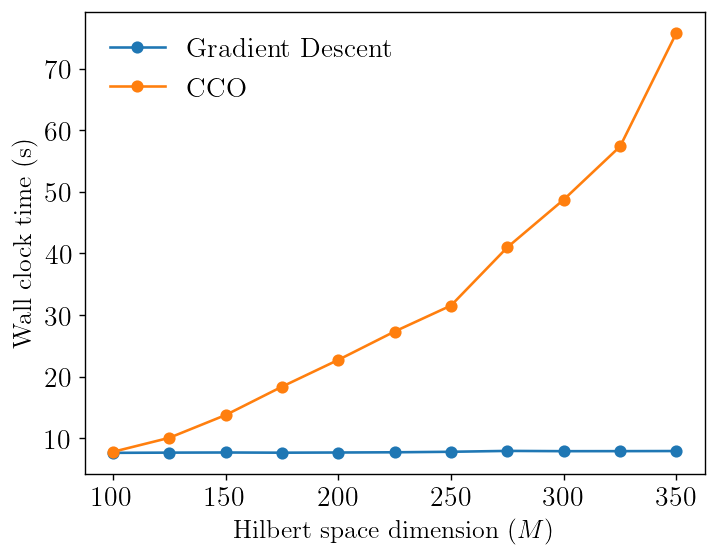

In [5]:
plt.plot(Ms, time_gd, label=r'\textrm{Gradient Descent}', marker="o")
plt.plot(Ms, time_mosek, label=r'\textrm{CCO}', marker="o")
plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.ylabel(r"\textrm{Wall clock time (s)}", fontsize=15)
# plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False);

if eta < 1.0:
    plt.savefig("figs/lossy/lossy_wall_clock.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_wall_clock.png", dpi=300, bbox_inches='tight')

In [6]:
time_per_iter_gd = [ t/hyperparams.num_epochs for t in time_gd ]

time_per_iter_mosek = [ t/iters for t, iters in zip(time_mosek, iters_mosek) ]

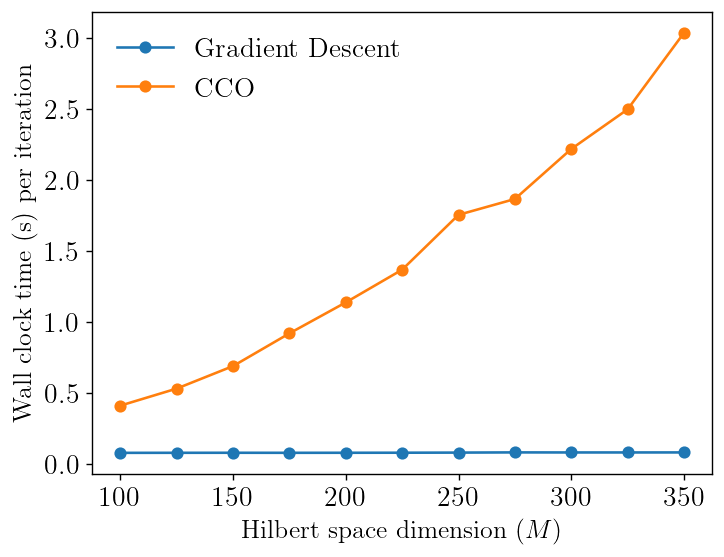

In [7]:
plt.plot(Ms, time_per_iter_gd, label=r'\textrm{Gradient Descent}', marker="o")
plt.plot(Ms, time_per_iter_mosek, label=r'\textrm{CCO}', marker="o")
plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.ylabel(r"$\textrm{Wall clock time (s) per iteration}$", fontsize=15)
# plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False);
if eta < 1.0:
    plt.savefig("figs/lossy/lossy_wall_iter.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_wall_iter.png", dpi=300, bbox_inches='tight')

In [8]:
gd_trials = 20
avg_fids_gd_sample = []
avg_mses_gd_sample = []


for M in tqdm(Ms, desc="Performing time experiments"):
    avg_fids_gd_M = []
    avg_mses_gd_M = []
    # PNR detector POVM
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_max(M, eps=1e-5)  # get max avg photon number for probes
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ]), dtype=th.float32) 

    targets = probes @ true_povm  
    
    M, N, = probes.shape[1], targets.shape[1]
    
    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)

    for i in range(gd_trials):
        
        logits = th.rand((M, N)) - 1
        logits = logits.to(device)
        logits.requires_grad = True    
        
        logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False)

        Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
        
        if check_diag_povm(Pi.T, tol=1e-5) is not True:
            print(f"WARNING: Gradient descent got invalid solution POVM for M={M}")

        Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_fids_gd_M.append(sum(Fs)/len(Fs))

        frobs = [ diag_mse_norm(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_mses_gd_M.append(sum(frobs)/len(frobs))
    
    avg_fids_gd_sample.append(avg_fids_gd_M)
    avg_mses_gd_sample.append(avg_mses_gd_M)

Performing time experiments: 100%|██████████| 11/11 [28:45<00:00, 156.91s/it]


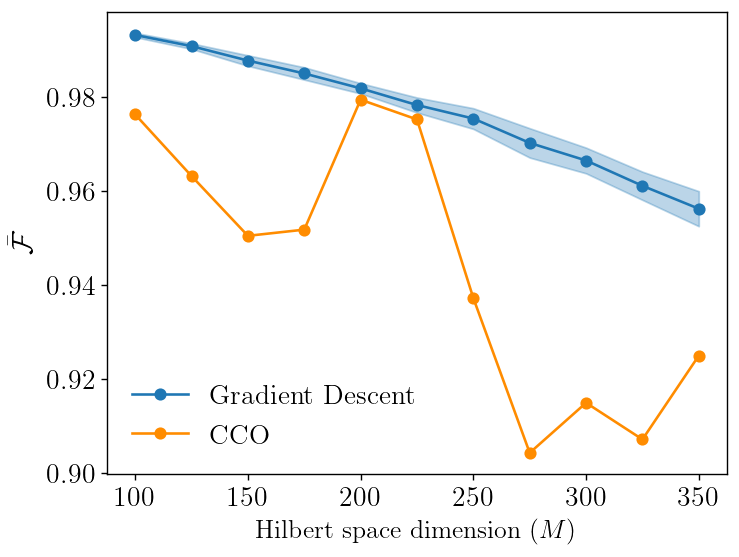

In [9]:
arr = np.array(avg_fids_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(Ms, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(Ms, lower, upper, color='C0', alpha=0.3)
plt.plot(Ms, avg_fids_cco, label=r'\textrm{CCO}', marker="o", color="darkorange")
plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.ylabel(r"$\bar{\mathcal{F}}$", fontsize=17.0)
# plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False);
if eta < 1.0:
    plt.savefig("figs/lossy/lossy_fidelity.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_fidelity.png", dpi=300, bbox_inches='tight')

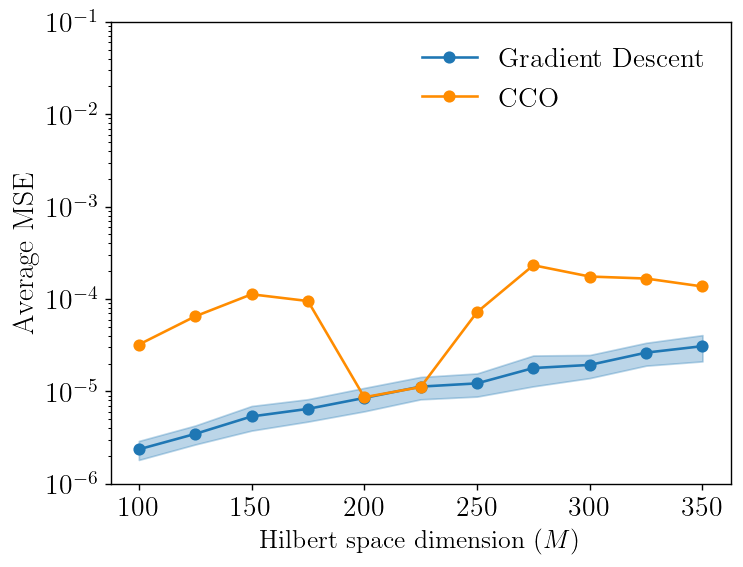

In [ ]:
arr = np.array(avg_mses_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(Ms, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(Ms, lower, upper, color='C0', alpha=0.3)

plt.plot(Ms, avg_mses_cco, label=r'\textrm{CCO}', marker="o", color="darkorange")

plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.ylabel(r"$\textrm{Average MSE}$", fontsize=17.0)

plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False);

if eta < 1.0:
    plt.savefig("figs/lossy/lossy_mse.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_mse.png", dpi=300, bbox_inches='tight')

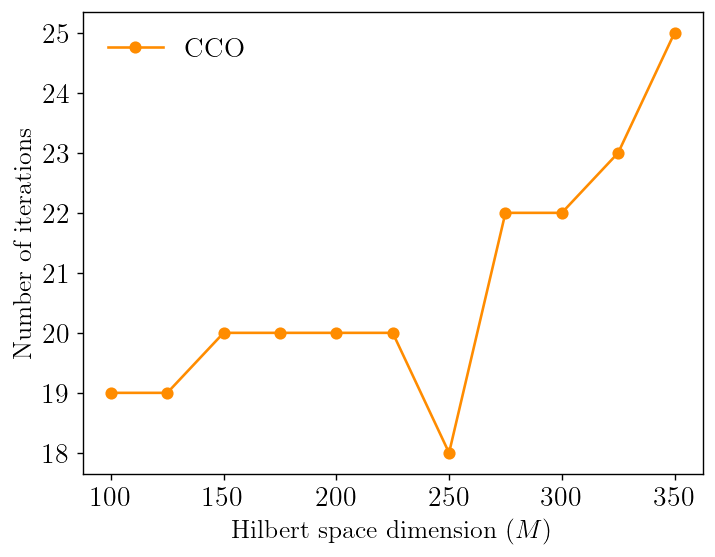

In [ ]:
plt.plot(Ms, iters_mosek, label=r'\textrm{CCO}', marker="o", color="darkorange")
plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.ylabel(r"$\textrm{Number of iterations}$", fontsize=15.0)
plt.legend(fancybox=True, ncol=1, frameon=False);
if eta < 1.0:
    plt.savefig("figs/lossy/lossy_iters.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig("figs/ideal/ideal_iters.png", dpi=300, bbox_inches='tight')